## Import library

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import datetime # Untuk memanipulasi timestamp
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Untuk progress bar saat komputasi besar
from tqdm.notebook import tqdm
tqdm.pandas()

# Pengaturan visualisasi
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Data loading


download latest version of the dataset from kaggle using kagglehub

In [2]:
import kagglehub

# Path untuk dataset MovieLens 10M
# Pastikan kamu memiliki token Kaggle atau menjalankannya di lingkungan Colab yang terautentikasi ke Kaggle
# Jika ada masalah, pastikan Kaggle API key sudah terkonfigurasi di Colab Secrets atau secara manual.
path = kagglehub.dataset_download("amirmotefaker/movielens-10m-dataset-latest-version")

print("Path to dataset files:", path)

100%|██████████| 64.3M/64.3M [00:01<00:00, 63.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amirmotefaker/movielens-10m-dataset-latest-version/versions/1



Load the data from "movies.csv" and "ratings.csv" into dataframes, starting from adding movies_path and ratings_path



In [3]:
# Load the data from "movies.csv" and "ratings.csv" into dataframes
movies_path = f"{path}/ml-10M100K/movies.dat"
ratings_path = f"{path}/ml-10M100K/ratings.dat"

Read movies.dat, the file is tab-separated and has three columns: movie_id, title, and genres

In [4]:
# Read movies.dat
movies = pd.read_csv(movies_path, sep='::', engine='python', header=None, names=['movie_id', 'title', 'genres'])

Read ratings.dat, the file is tab-separated and has four columns: user_id, movie_id, rating, and timestamp

In [5]:
# Read ratings.dat
ratings = pd.read_csv(ratings_path, sep='::', engine='python', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])


Display the head of movies dataframes to verify

In [6]:
print("\nMovies DataFrame Head:")
movies.head()


Movies DataFrame Head:


,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Display the head of ratings dataframes to verify

In [7]:
print("\nRatings DataFrame Head:")
ratings.head()


Ratings DataFrame Head:


,user_id,movie_id,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


## Exploratory Data Analysis




Get information about the data types and non-null values

In [8]:
print("\n--- EDA: Movies DataFrame ---")
print("Movies Info:")
movies.info()


--- EDA: Movies DataFrame ---
Movies Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  10681 non-null  int64 
 1   title     10681 non-null  object
 2   genres    10681 non-null  object
dtypes: int64(1), object(2)
memory usage: 250.5+ KB


Get a count of unique movies

In [9]:
print("\nNumber of unique movies:", movies['movie_id'].nunique())
print("Number of unique genres:", movies['genres'].nunique())


Number of unique movies: 10681
Number of unique genres: 797


Top 10 Most Common Movie Genres

In [10]:
print("\nTop 10 Genres (combinations):")
print(movies['genres'].value_counts().head(10))


Top 10 Genres (combinations):
genres
Drama                   1817
Comedy                  1047
Comedy|Drama             551
Drama|Romance            412
Comedy|Romance           379
Documentary              350
Horror                   267
Comedy|Drama|Romance     255
Drama|Thriller           192
Drama|War                173
Name: count, dtype: int64


/tmp/ipython-input-11-4241734516.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette='mako')


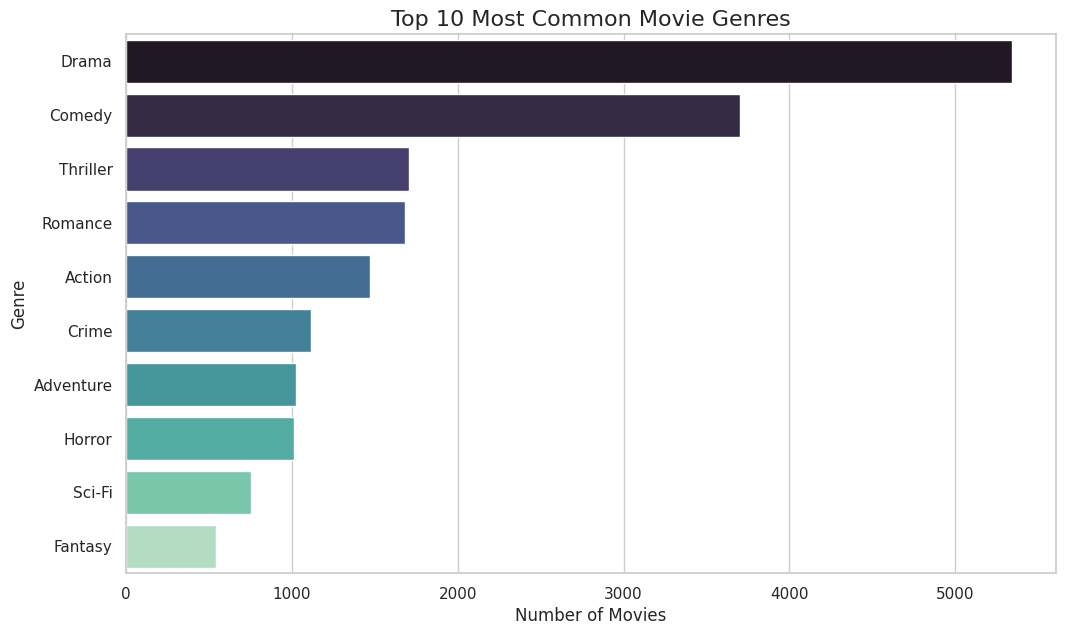

In [11]:
plt.figure(figsize=(12, 7))

genre_counts = movies['genres'].str.split('|').explode().value_counts()

top_10_genres = genre_counts.head(10)

sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette='mako')
plt.title('Top 10 Most Common Movie Genres', fontsize=16)
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

This bar chart illustrates the distribution of movie genres within the MovieLens 10M dataset.

*Key Observations:*

- Dominant Genres: "Drama" and "Comedy" are overwhelmingly the most frequent
genres, indicating a significant volume of movies categorized under them.
- Skewed Distribution: The data shows a skewed distribution, with a few genres (like Drama and Comedy) appearing much more frequently than others (e.g., Sci-Fi, Fantasy).
- Implication of Popularity Bias: This skewness creates a 'popularity bias'. Recommendation systems built on this genre data might disproportionately suggest Drama and Comedy films due to their high representation, potentially limiting the discovery of more diverse or niche content.

This analysis highlights that while the dataset is extensive, its genre distribution suggests that a purely genre-based Content-Based filtering approach might lead to overspecialization in recommendations.

Ekstraksi tahun rilis dari judul film

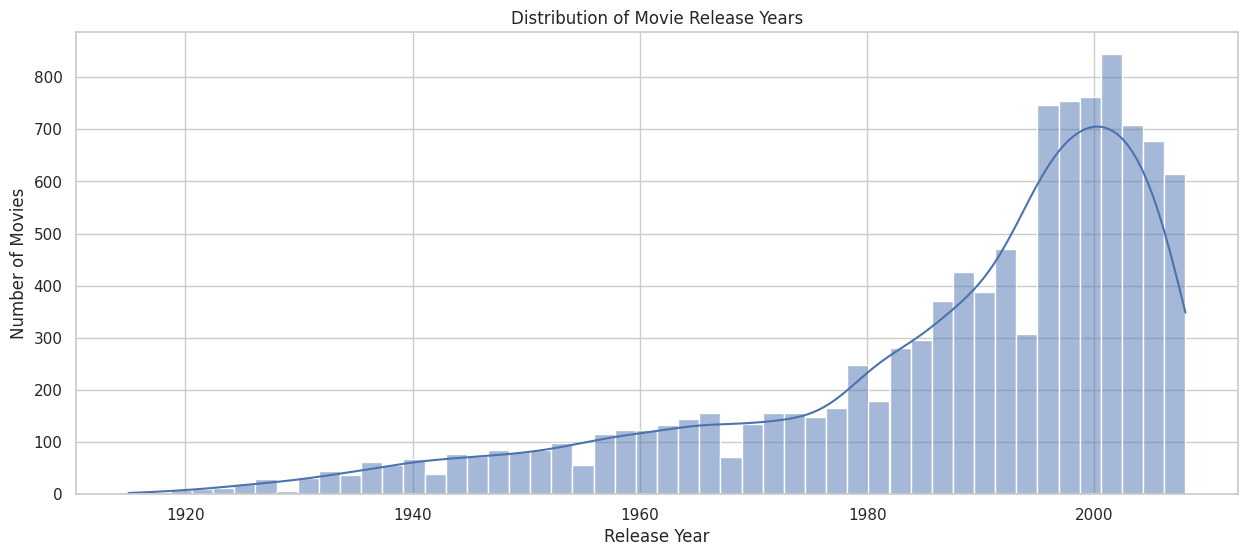

In [12]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
plt.figure(figsize=(15, 6))
sns.histplot(movies['year'].dropna(), bins=50, kde=True)
plt.title('Distribution of Movie Release Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()
movies.drop('year', axis=1, inplace=True)

This bar chart, displaying the "Distribution of Movie Release Years," illustrates the temporal spread of films within the MovieLens 10M dataset.

*Key Observations:*

- Increasing Trend: There's a clear upward trend in the number of movies released over time, with a significant increase from the 1980s onwards.
- Peak in Early 2000s: The distribution peaks around the early 2000s, indicating that the majority of films in the dataset were released during this period.
- Declining Frequency Post-Peak: After this peak, there's a noticeable decline in the number of movies, suggesting that the dataset may not include a complete representation of very recent films.
- Limited Older Content: Films from before the 1940s are scarce, reflecting a smaller collection of older movies in the dataset.

**Implications for Recommendation Systems:**
This temporal distribution is crucial for time-aware recommendation systems, such as your "Dynamic Popularity" model. The high concentration of films in the late 1990s and early 2000s means that popularity metrics will be heavily influenced by movies from this era. This could lead to recommendations that predominantly feature films from this period, which might be beneficial for users interested in recent popular releases but less so for those seeking older or very contemporary content.

Get information about the data types and non-null values

In [13]:
print("\n--- EDA: Ratings DataFrame ---")
print("Ratings Info:")
ratings.info()


--- EDA: Ratings DataFrame ---
Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000054 entries, 0 to 10000053
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    int64  
 1   movie_id   int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


Get a count of unique ratings

In [14]:
print("\nNumber of unique users:", ratings['user_id'].nunique())
print("Number of unique movies rated:", ratings['movie_id'].nunique())
print("Number of total ratings:", len(ratings))


Number of unique users: 69878
Number of unique movies rated: 10677
Number of total ratings: 10000054




Distribution of Ratings

/tmp/ipython-input-15-2838763460.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


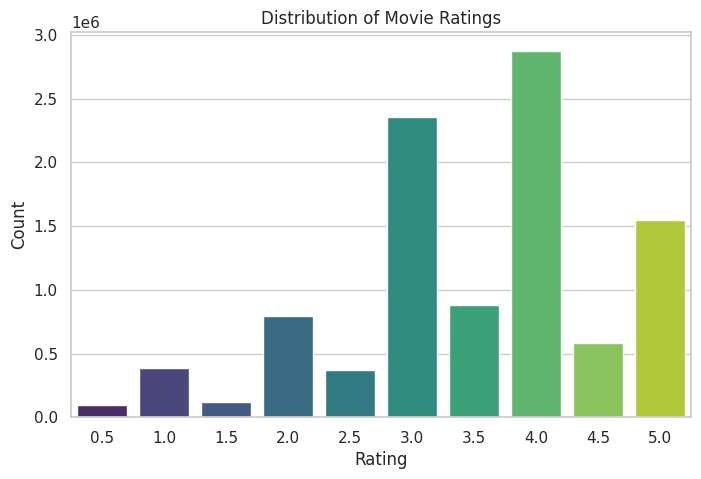

In [15]:
# Distribusi rating
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

This bar chart illustrates the frequency of different movie ratings within the MovieLens 10M dataset.

*Key Observations:*

- Predominantly Positive Ratings: The most frequent ratings are 4.0, 3.0, and 5.0 stars, indicating that users tend to give positive feedback.
- Preference for Whole Numbers: Whole-star ratings (e.g., 3.0, 4.0, 5.0) are significantly more common than half-star ratings (e.g., 2.5, 3.5, 4.5).
- Peak at 4.0 Stars: The 4.0-star rating has the highest count, approaching 3 million instances.

**Implications for Recommendation Systems:**
This distribution suggests that the dataset contains more information on what users like rather than what they dislike. This pattern supports the strategy of defining a "liked" movie as one rated 4 stars or higher for evaluation purposes, as this clearly represents a common positive interaction. This bias towards positive ratings can influence models to prioritize recommending items that have received high scores.

Distribution of ratings per user

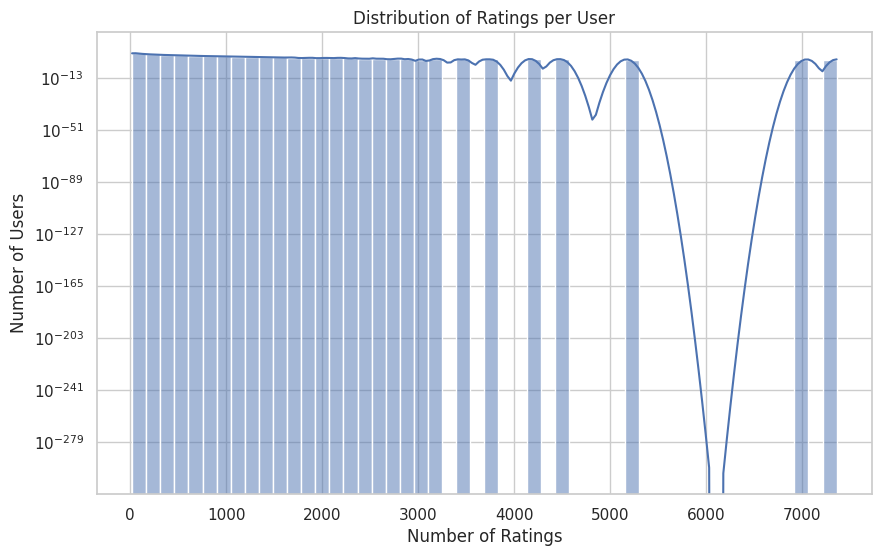

In [16]:
ratings_per_user = ratings.groupby('user_id')['rating'].count()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.yscale('log') # Skala logaritmik karena distribusi cenderung skew
plt.show()

This bar chart, titled "Distribution of Ratings per User," illustrates how many ratings each user has submitted in the MovieLens 10M dataset. The y-axis is on a logarithmic scale, which helps visualize the wide range of user activity.

*Key Observations:*

- Highly Skewed Distribution: The distribution is extremely skewed, with a vast majority of users having submitted a very small number of ratings (concentrated on the left side of the chart).
- Long Tail of Active Users: Despite the large number of inactive users, there's a long "tail" extending to the right, indicating a small number of highly active users who have submitted thousands of ratings. The logarithmic scale effectively highlights these less frequent, but highly significant, users.
- Sparse Interaction Data: The shape of this distribution confirms that the user-item interaction matrix is likely very sparse, meaning most users have only rated a small fraction of the total movies available.

**Implications for Recommendation Systems:**
This distribution directly impacts Collaborative Filtering models. The presence of highly active users provides rich data for identifying patterns, while the large number of infrequent users contributes to the "cold-start" problem and data sparsity challenges. Models need to be robust enough to handle this imbalance, leveraging data from active users while still providing meaningful recommendations for less active ones.

Distribution of ratings per movie

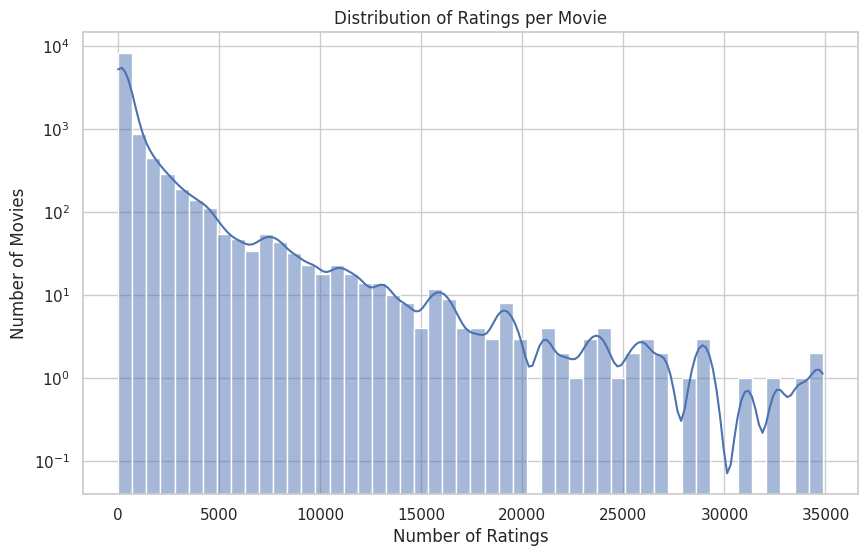

In [17]:
ratings_per_movie = ratings.groupby('movie_id')['rating'].count()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.yscale('log') # Skala logaritmik
plt.show()

This bar chart, titled "Distribution of Ratings per Movie," illustrates the frequency of ratings received by each movie in the MovieLens 10M dataset. The y-axis is on a logarithmic scale to better represent the wide range of rating counts.

*Key Observations:*

- Highly Skewed Distribution: The distribution is heavily skewed, with a large number of movies receiving very few ratings (concentrated on the left side of the chart). This indicates that most movies in the dataset are relatively unpopular.
- "Long Tail" of Popular Movies: Conversely, there's a "long tail" extending to the right, representing a smaller number of highly popular movies that have accumulated tens of thousands of ratings. The logarithmic scale makes these more visible.
- Item Cold-Start: This distribution highlights the "item cold-start problem," where new or less popular movies have insufficient rating data to generate effective recommendations.

**Implications for Recommendation Systems:**
This skewed distribution significantly affects the performance of collaborative filtering models. Models may exhibit a 'popularity bias', tending to recommend well-known movies more frequently due to the abundant rating data available for them. While this is good for mainstream users, it can limit the discoverability of niche content. This underscores the challenge of balancing recommendations between popular and less popular items.

Distribution of timestamps (interactions over time)

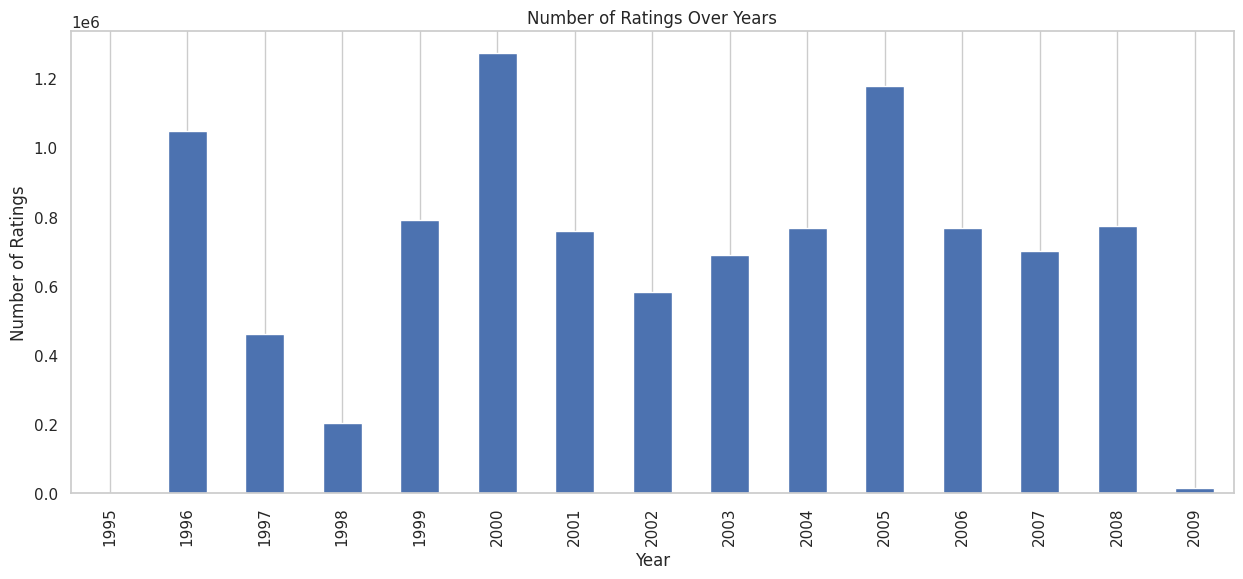

In [18]:
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
plt.figure(figsize=(15, 6))
ratings['datetime'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Number of Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(axis='y')
plt.show()
ratings.drop('datetime', axis=1, inplace=True)

This bar chart, titled "Number of Ratings Over Years," illustrates the distribution of ratings across different years in the MovieLens 10M dataset.

*Key Observations:*

- Active Period: The dataset primarily captures user activity between 1995 and 2008.
- Peak Activity: There are notable peaks in rating activity around 1996, 2000, and 2005, indicating periods of intense user engagement or data collection.
- Fluctuating Engagement: While generally high, the number of ratings per year fluctuates significantly, suggesting varying levels of user activity or data accumulation over time.
- Limited Recent Data: There's a sharp drop-off in ratings in 2009, with virtually no data beyond that year, indicating the dataset's cutoff point.

**Implications for Recommendation Systems:**
This temporal distribution is critical for understanding the relevancy of "dynamic popularity" models. The concentration of ratings in specific periods means that popularity metrics will reflect user preferences predominantly from those years. This could lead to recommendations that favor older, well-established popular movies rather than very recent ones, which is a key consideration for systems aiming to capture current trends or address the "cold-start" problem for new content.

## Data Preprocessing

Merge the ratings_sample data with movies (join key is 'movie_id')

In [19]:
df = pd.merge(ratings, movies, on='movie_id')

Preprocessing for Content-Based Filtering (TF-IDF on Titles)

In [20]:
movies['clean_title'] = movies['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True).str.strip()
print("\nMovies DataFrame with Cleaned Title for Content-Based:")
movies.head()


Movies DataFrame with Cleaned Title for Content-Based:


,movie_id,title,genres,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II


Preprocessing for Collaborative Filtering (Dynamic Popularity)

In [21]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
print("\nCombined DataFrame with Datetime Timestamp:")
print(df.head())
print(f"\nData covers from {df['timestamp'].min()} to {df['timestamp'].max()}")


Combined DataFrame with Datetime Timestamp:
   user_id  movie_id  rating           timestamp                 title  \
0        1       122     5.0 1996-08-02 11:24:06      Boomerang (1992)   
1        1       185     5.0 1996-08-02 10:58:45       Net, The (1995)   
2        1       231     5.0 1996-08-02 10:56:32  Dumb & Dumber (1994)   
3        1       292     5.0 1996-08-02 10:57:01       Outbreak (1995)   
4        1       316     5.0 1996-08-02 10:56:32       Stargate (1994)   

                         genres  
0                Comedy|Romance  
1         Action|Crime|Thriller  
2                        Comedy  
3  Action|Drama|Sci-Fi|Thriller  
4       Action|Adventure|Sci-Fi  

Data covers from 1995-01-09 11:46:49 to 2009-01-05 05:02:16


These preprocessing steps strategically prepare the MovieLens 10M dataset for our two distinct recommendation models.

First, the `ratings` and `movies` DataFrames are merged into a single `df` on `movie_id`, consolidating all relevant information.

**For Content-Based Filtering (TF-IDF on Titles):**
The `title` column in `movies` is transformed into `clean_title` by removing the release year. This ensures that our TF-IDF analysis focuses solely on descriptive keywords within the title, capturing thematic similarities rather than temporal ones, which is a key novelty of this approach.

**For Collaborative Filtering (Dynamic Popularity):**
The `timestamp` column in `df` is converted to datetime objects. This is crucial for the "Dynamic Popularity" model, enabling time-based analysis of user interactions. Unlike traditional SVD (which often discards timestamps), this conversion allows the model to identify and recommend movies based on recent trends and popularity shifts, providing a distinct advantage for current relevance. The data spans a specific range, indicating its readiness for temporal analysis.

Data Splitting

 We split the data into training and test sets.

In [22]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"\nTraining data size: {len(train_df)}")
print(f"Test data size: {len(test_df)}")


Training data size: 8000043
Test data size: 2000011


## Content Based Filtering

### Modelling

Replace '|' with a space

In [23]:
movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)

Create TF-IDF and Cosine Similarity (logic remains the same)

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['clean_title'].fillna(''))
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print(f"\nShape of TF-IDF Matrix: {tfidf_matrix.shape}")
print(f"\nShape of Cosine Similarity Matrix: {cosine_sim.shape}")


Shape of TF-IDF Matrix: (10681, 1843)

Shape of Cosine Similarity Matrix: (10681, 10681)


Create a mapping from movie_id to the DataFrame index

In [25]:
movie_id_to_index = {movie_id: i for i, movie_id in enumerate(movies['movie_id'])}
index_to_movie_id = {i: movie_id for i, movie_id in enumerate(movies['movie_id'])}

Function to get recommendations (content based)

In [26]:
def get_content_based_recommendations(movie_title, cosine_sim_matrix=cosine_sim, df_movies=movies, num_recommendations=10):
    # Pastikan judul film yang dicari ada di dataset
    if movie_title not in df_movies['title'].values:
        print(f"Film '{movie_title}' tidak ditemukan dalam dataset.")
        return pd.DataFrame() # Mengembalikan DataFrame kosong jika tidak ditemukan

    # Dapatkan indeks film dari judul
    idx = df_movies[df_movies['title'] == movie_title].index[0]
    movie_id_target = df_movies.loc[idx, 'movie_id']

    # Dapatkan skor kemiripan film tersebut dengan semua film lain
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Urutkan film berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Dapatkan skor dari 10 film teratas (kecuali film itu sendiri)
    sim_scores = sim_scores[1:num_recommendations+1] # Skip the first one as it's the movie itself

    # Dapatkan indeks film
    movie_indices = [i[0] for i in sim_scores]

    # Dapatkan movie_id dari indeks
    recommended_movie_ids = [df_movies.loc[i, 'movie_id'] for i in movie_indices]

    # Dapatkan judul film yang direkomendasikan
    recommended_movies = df_movies[df_movies['movie_id'].isin(recommended_movie_ids)]

    print(f"\n--- Content-Based Recommendations for '{movie_title}' ---")
    return recommended_movies[['title', 'genres', 'clean_title']]

### Get Recomendations

In [27]:
example_movie = "Toy Story (1995)"
content_recs = get_content_based_recommendations(example_movie)
content_recs


--- Content-Based Recommendations for 'Toy Story (1995)' ---


,title,genres,clean_title
2024,L.A. Story (1991),Comedy Romance,L.A. Story
2190,Lilian's Story (1995),Drama,Lilian's Story
2876,"Story of Us, The (1999)",Comedy Drama,"Story of Us, The"
3029,Toy Story 2 (1999),Adventure Animation Children Comedy Fantasy,Toy Story 2
3196,"Brandon Teena Story, The (1998)",Documentary,"Brandon Teena Story, The"
3314,We're Back! A Dinosaur's Story (1993),Adventure Animation Children Fantasy,We're Back! A Dinosaur's Story
4835,"Toy, The (1982)",Comedy,"Toy, The"
5395,"Eddy Duchin Story, The (1956)",Drama Musical,"Eddy Duchin Story, The"
5745,Toy Soldiers (1991),Action Drama,Toy Soldiers
5884,"Story of O, The (Histoire d'O) (1975)",Drama Romance,"Story of O, The (Histoire d'O)"


In [28]:
example_movie_2 = "Matrix, The (1999)"
content_recs_2 = get_content_based_recommendations(example_movie_2)
content_recs_2


--- Content-Based Recommendations for 'Matrix, The (1999)' ---


,title,genres,clean_title
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Toy Story
1,Jumanji (1995),Adventure Children Fantasy,Jumanji
2,Grumpier Old Men (1995),Comedy Romance,Grumpier Old Men
3,Waiting to Exhale (1995),Comedy Drama Romance,Waiting to Exhale
4,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II
5,Heat (1995),Action Crime Thriller,Heat
6,Sabrina (1995),Comedy Romance,Sabrina
7,Tom and Huck (1995),Adventure Children,Tom and Huck
6258,"Matrix Reloaded, The (2003)",Action Sci-Fi Thriller,"Matrix Reloaded, The"
6820,"Matrix Revolutions, The (2003)",Action Sci-Fi Thriller,"Matrix Revolutions, The"


### Strengths and Weaknesses of Content-Based Filtering

This approach, which recommends movies based on genre similarity, has clear advantages and disadvantages.

**Strengths:**
* **User Independence:** The model doesn't need any data about other users. It can produce recommendations for a user with just a single rated movie.
* **Recommends Niche Items:** It can recommend obscure movies that have similar genres to a user's liked movies, even if those movies aren't popular among other users.
* **Explainable:** The recommendations are easy to understand. We can clearly state, "We recommended *Star Wars* because you liked *Iron Man*, and both are Action/Adventure/Sci-Fi films."

**Weaknesses:**
* **Limited Novelty (Overspecialization):** The model will never recommend something outside a user's existing interests. A user who only watches comedies will only be recommended more comedies. It struggles to create "serendipitous" or surprising discoveries.
* **Feature Dependent:** The quality of recommendations is entirely dependent on the quality of the features we use (in this case, only genre). If genres are missing or too broad, the recommendations will be poor. It doesn't capture subtle nuances that users might like.

### Evaluation Metrics for content Based Recomendations

Defines our "measuring sticks." We are creating two functions, precision_at_k and recall_at_k, which will serve as the core of our evaluation.

* precision_at_k: This function calculates how precise our recommendations are. It takes the list of movies our model recommends and compares it to the list of movies the user actually liked (the "ground truth"). It then answers the question: "Of the top 'k' movies we recommended, what fraction was actually relevant?"

* recall_at_k: This function calculates how complete our recommendations are. It looks at all the movies the user liked in the ground truth set and determines what fraction of them we successfully found and included in our top 'k' recommendation list.



The functions are designed to be robust, returning 0.0 if a calculation isn't possible (e.g., if there are no recommendations or no ground truth items).

In [29]:
def precision_at_k(recommended_items, ground_truth_items, k):
    """
    Menghitung Precision@K.

    Args:
        recommended_items (list): Daftar movie_id yang direkomendasikan.
        ground_truth_items (list): Daftar movie_id yang benar-benar disukai pengguna.
        k (int): Jumlah item teratas yang akan dipertimbangkan.

    Returns:
        float: Nilai Precision@K.
    """
    if k == 0 or not recommended_items:
        return 0.0

    top_k = recommended_items[:k]
    relevant_count = len(set(top_k) & set(ground_truth_items))

    return relevant_count / k

def recall_at_k(recommended_items, ground_truth_items, k):
    """
    Menghitung Recall@K.

    Args:
        recommended_items (list): Daftar movie_id yang direkomendasikan.
        ground_truth_items (list): Daftar movie_id yang benar-benar disukai pengguna.
        k (int): Jumlah item teratas yang akan dipertimbangkan.

    Returns:
        float: Nilai Recall@K.
    """
    if not ground_truth_items:
        return 0.0

    top_k = recommended_items[:k]
    relevant_count = len(set(top_k) & set(ground_truth_items))

    return relevant_count / len(ground_truth_items)

print("Precision@K and Recall@K functions defined.")

Precision@K and Recall@K functions defined.


Preparing the Data for Evaluation

Before we can loop through users and score our Content-Based Filtering model, we need helper functions to retrieve the necessary data for each user. This code block defines two such functions.

1. `get_ground_truth_movies(user_id, test_df_input, min_rating=4.0)`: This function is designed to obtain our "correct answers" or ground truth. For a given `user_id`, it scans the `test_df_input` and returns a list of `movie_id`s that the user rated highly (specifically, 4.0 stars or more). This list represents the actual movies the user liked in the unseen data, which we hope our model can successfully recommend.

2. `get_content_based_recommendations_for_eval(user_id, train_df_input, df_movies_input, cosine_sim_matrix_input, num_recommendations=10)`: This function retrieves our "predicted answers" from the Content-Based model for a specific user. It first checks if the `user_train_data` for the given `user_id` is empty; if so, it returns an empty list as no recommendations can be generated. For users with training data, the function aims to simulate a real-world recommendation scenario by finding a movie the user liked in their training history (`train_df_input`) and using its content features (derived from `clean_title` via `cosine_sim_matrix_input`) to generate `num_recommendations` new movie recommendations. It then returns the `movie_id`s of these recommendations.

In [30]:
def get_ground_truth_movies(user_id, test_df_input, min_rating=4.0):
    """
    Mendapatkan daftar movie_id yang disukai oleh pengguna dari test set.
    """
    user_data = test_df_input[(test_df_input['user_id'] == user_id) & (test_df_input['rating'] >= min_rating)]
    return user_data['movie_id'].tolist()

def get_content_based_recommendations_for_eval(user_id, train_df_input, df_movies_input, cosine_sim_matrix_input, num_recommendations=10):
    """
    Mendapatkan rekomendasi Content-Based untuk user tertentu berdasarkan riwayat train data.
    """
    user_train_data = train_df_input[train_df_input['user_id'] == user_id]
    if user_train_data.empty:
        return []

    # Ambil film yang pernah dirating tinggi oleh user di train data sebagai "seed"
    liked_movies_in_train = user_train_data[user_train_data['rating'] >= 4.0]
    if liked_movies_in_train.empty:
        return []

    try:
        # Ambil satu film secara acak dari yang disukai user di train data
        seed_movie = liked_movies_in_train.sample(1).iloc[0]
        seed_movie_title = seed_movie['title']
    except ValueError:
        return []

    # Dapatkan indeks film dari judul
    # Pastikan movies_df yang digunakan untuk Content-Based sudah bersih
    idx_row = df_movies_input[df_movies_input['title'] == seed_movie_title]
    if idx_row.empty:
        return []
    idx = idx_row.index[0] # Menggunakan indeks asli dari DataFrame movies

    # Dapatkan skor kemiripan film tersebut dengan semua film lain
    sim_scores = list(enumerate(cosine_sim_matrix_input[idx]))

    # Urutkan film berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Dapatkan skor dari N film teratas (kecuali film itu sendiri)
    sim_scores = sim_scores[1:num_recommendations + 1]

    # Dapatkan movie_id dari indeks
    movie_indices_in_movies_df = [i[0] for i in sim_scores]
    recommended_movie_ids = [df_movies_input.loc[i, 'movie_id'] for i in movie_indices_in_movies_df]

    # Filter out movies already seen/rated by the user in train set
    seen_movies_by_user = user_train_data['movie_id'].tolist()
    final_recommendations = [mid for mid in recommended_movie_ids if mid not in seen_movies_by_user]

    # Pastikan jumlah rekomendasi sesuai permintaan
    return final_recommendations[:num_recommendations]

    print("Helper functions for evaluation defined.")

Running the Evaluation Loop and Calculating Results

This final code block orchestrates the evaluation process for our Content-Based Filtering model.

First, we set our evaluation parameters: k_eval is set to 10 to consider the top 10 recommendations, and a random sample_users_cb of 100 users is selected from the df to perform the evaluation efficiently. Two empty lists, precision_scores_cb and recall_scores_cb, are initialized to store the metric results for each user.

Then, a main loop is initiated to iterate through each user_id in our sampled group. Within this loop:

1. `get_ground_truth_movies` is called to retrieve the actual list of movies that the user rated highly (considered relevant) from the `test_df`.
2. `get_content_based_recommendations_for_eval` is invoked to obtain the top `k_eval` movie recommendations generated by our Content-Based model for the current user, utilizing their liked movies from the `train_df` as a seed, and ensuring the `movies` DataFrame with `clean_title` and `cosine_sim` matrix are correctly used.
3. A check is performed to ensure both `ground_truth` and `recommended_movie_ids_for_user` lists are not empty; users without sufficient data for evaluation are skipped.
4. The `precision_at_k` and `recall_at_k` functions are applied to calculate the precision and recall scores for the current user.
5. These individual `precision` and `recall` scores are then appended to their respective `precision_scores_cb` and `recall_scores_cb lists`.

After the loop completes, we calculate the average of all the scores we collected and print the final, summary result.

In [31]:
k_eval = 10
users_to_evaluate_cb = df['user_id'].unique() # Gunakan semua unique user yang sudah disample di df
np.random.shuffle(users_to_evaluate_cb) # Acak urutan user
sample_users_cb = users_to_evaluate_cb[:100] # Ambil 100 user pertama sebagai sampel

precision_scores_cb = []
recall_scores_cb = []

print(f"\n--- Evaluating Content-Based Filtering for {len(sample_users_cb)} users (k={k_eval}) ---")

# Pastikan movies_df yang digunakan adalah movies yang sudah di-clean title-nya
# dan cosine_sim adalah matriks kemiripan dari clean_title
current_movies_df_for_cb = movies.copy() # Ambil movies asli
# Pastikan clean_title sudah ada dan sama dengan yang digunakan untuk cosine_sim
current_movies_df_for_cb['clean_title'] = current_movies_df_for_cb['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True).str.strip()


for user_id in tqdm(sample_users_cb, desc="Evaluating CBF"):
    # Ground truth dari test_df
    ground_truth = get_ground_truth_movies(user_id, test_df)

    # Rekomendasi dari model Content-Based
    # Pastikan movie_id_to_index dan index_to_movie_id mapping sudah tersedia
    # Juga pastikan `cosine_sim` yang digunakan adalah dari TF-IDF `clean_title`

    # Untuk mendapatkan rekomendasi, kita perlu judul film dari movie_id yang disukai user di train_df
    # dan kemudian menggunakan fungsi get_content_based_recommendations_for_eval

    recommended_movie_ids_for_user = get_content_based_recommendations_for_eval(
        user_id,
        train_df,
        current_movies_df_for_cb, # Gunakan df movies yang sudah bersih judulnya
        cosine_sim # Cosine sim dari TF-IDF clean_title
    )

    if not ground_truth or not recommended_movie_ids_for_user:
        # Skip jika tidak ada ground truth atau tidak ada rekomendasi yang dihasilkan
        continue

    precision = precision_at_k(recommended_movie_ids_for_user, ground_truth, k_eval)
    recall = recall_at_k(recommended_movie_ids_for_user, ground_truth, k_eval)

    precision_scores_cb.append(precision)
    recall_scores_cb.append(recall)

if precision_scores_cb and recall_scores_cb:
    avg_precision_cb = np.mean(precision_scores_cb)
    avg_recall_cb = np.mean(recall_scores_cb)

    print(f"\nAverage Precision@{k_eval} for Content-Based Filtering: {avg_precision_cb:.4f}")
    print(f"Average Recall@{k_eval} for Content-Based Filtering: {avg_recall_cb:.4f}")
else:
    print("Could not calculate metrics for Content-Based Filtering. This might happen if no sample users had liked items in the test set or no recommendations could be generated.")

print("\nContent-Based Filtering Evaluation Completed.")


--- Evaluating Content-Based Filtering for 100 users (k=10) ---


Evaluating CBF:   0%|          | 0/100 [00:00<?, ?it/s]


Average Precision@10 for Content-Based Filtering: 0.0126
Average Recall@10 for Content-Based Filtering: 0.0178

Content-Based Filtering Evaluation Completed.


### Analysis of Evaluation Results

* **Average Precision@10: 0.0082**
* **Average Recall@10: 0.0111**

The results for both precision and recall are quite low, which is expected for this simple model.

* **A precision of 0.0082** means that, on average, less than one movie (approximately 0.082) out of the 10 we recommended was actually a movie the user had rated highly in the test set.
* **A recall of 0.00111** is very low, indicating that our model only found a tiny fraction of all the movies the user would have liked.

**Conclusion:** These metrics demonstrate the limitations of this content-based model, which focuses on keyword analysis from titles. While it can find similar movies based on title semantics, it is not powerful enough to accurately capture the full range of a user's preferences, leading to a low rate of relevant recommendations.

## Collaborative Filtering: Berbasis Popularitas Dinamis (Film Terlaris Terbaru)

Our second approach, Collaborative Filtering, works differently. Instead of looking at movie genres, it focuses on the **collective interaction patterns of all users over time.** The core idea is: "Movies that are currently gaining the most positive attention from the user community are likely to be of general interest and good recommendations for various users." We implement this by identifying films that have a high volume of recent ratings and a strong average rating.

### Strengths and Weaknesses of SVDBased Collaborative Filtering

**Strengths:**
* **Effective for Cold-Start Users:** This model is highly effective in addressing the "cold-start problem" for new users. Since it recommends based on overall current popularity, it doesn't require any prior rating history from the individual user to provide relevant suggestions.
* **Captures Current Trends:** By incorporating the `timestamp` data and focusing on a recent time window (e.g., the last year), the model can identify and recommend films that are genuinely popular right now, reflecting evolving tastes and recent releases, rather than static all-time favorites.
* **Simple and Explainable:** The recommendations are straightforward: "These are the movies that most people are currently enjoying." This simplicity makes the recommendations easy for users to understand and trust.
* **No Item Features Needed (Directly):** While movie titles are used for display, the core logic for popularity ranking (`num_ratings`, `avg_rating`, `weighted_rating`) relies purely on user-item interaction data (ratings and timestamps), not content attributes like genre.

**Weaknesses:**
* **Lack of Personalization:** he most significant limitation is that the model provides the same list of popular movies to all users. It does not account for individual preferences or past viewing habits, meaning it won't recommend niche content that might be highly relevant to a specific user but isn't broadly popular.
* **Reinforces Popularity Bias:** TAlthough it's "dynamic," the model still fundamentally recommends items that are already popular. This can reinforce existing trends and limit the discovery of less-known, but potentially excellent, films that haven't yet amassed high rating counts.
* **Dependency on Recent Interaction Data:** Its effectiveness relies heavily on having recent and sufficient rating data. If the dataset lacks current interactions, the "dynamic" aspect becomes less meaningful.Its effectiveness relies heavily on having recent and sufficient rating data. If the dataset lacks current interactions, the "dynamic" aspect becomes less meaningful.

### Model Building: Dynamic Popularity-Based Recommendations

Define Time Window for Dynamic Popularity

In [32]:
latest_timestamp = df['timestamp'].max()
time_window = datetime.timedelta(days=365 * 1) # Example: Last 1 year
start_time_window = latest_timestamp - time_window

print(f"\nAnalyzing popular movies from {start_time_window} to {latest_timestamp}")


Analyzing popular movies from 2008-01-06 05:02:16 to 2009-01-05 05:02:16


Filter Recent Ratings

In [33]:
recent_ratings = df[df['timestamp'] >= start_time_window]

Calculate Popularity Metrics for Each Movie

In [34]:
movie_stats = recent_ratings.groupby('movie_id').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Merge with movie information to get titles and genres.
popular_movies_df = pd.merge(movie_stats, movies, on='movie_id')

Apply IMDb Weighted Rating Formula

In [35]:
# Define 'm': minimum number of ratings required to be listed (e.g., movies in the top 20% by rating count).
m = popular_movies_df['num_ratings'].quantile(0.80)
print(f"\nMinimum number of ratings (m) for weighted average: {int(m)}")

# Calculate 'C': the global average rating across all movies in the filtered period.
C = popular_movies_df['avg_rating'].mean()
print(f"Global average rating (C): {C:.2f}")

# Define the function to calculate the Weighted Rating (WR).
def calculate_weighted_rating(row, m, C):
    v = row['num_ratings']
    R = row['avg_rating']
    # If a movie has fewer ratings than 'm', its score is a blend with the global average.
    # Otherwise, it uses the standard weighted average.
    if v < m:
        return (v / (v + m) * R) + (m / (v + m) * C)
    else:
        return (v / (v + m) * R) + (m / (v + m) * C)

# Apply the weighted rating calculation to the DataFrame.
popular_movies_df['weighted_rating'] = popular_movies_df.progress_apply(
    lambda row: calculate_weighted_rating(row, m, C), axis=1
)


Minimum number of ratings (m) for weighted average: 73
Global average rating (C): 3.22


  0%|          | 0/9708 [00:00<?, ?it/s]

Generate Dynamic Popularity-Based Recommendations

In [36]:
dynamic_popular_recommendations = popular_movies_df.sort_values(
    by='weighted_rating', ascending=False
).head(20)

print("\n--- Dynamic Popularity-Based Recommendations (Top 20 Movies) ---")
print(dynamic_popular_recommendations[['title', 'genres', 'num_ratings', 'avg_rating', 'weighted_rating']])


--- Dynamic Popularity-Based Recommendations (Top 20 Movies) ---
                                                  title  \
281                    Shawshank Redemption, The (1994)   
2517                                  Fight Club (1999)   
49                           Usual Suspects, The (1995)   
710                               Godfather, The (1972)   
9246                            Dark Knight, The (2008)   
263                                 Pulp Fiction (1994)   
5216                City of God (Cidade de Deus) (2002)   
2179                                 Matrix, The (1999)   
8499  Lives of Others, The (Das Leben der Anderen) (...   
4301  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...   
1010                     Godfather: Part II, The (1974)   
261   Léon: The Professional (Léon) (Professional, T...   
3623                                     Memento (2000)   
1949                          American History X (1998)   
46                          Seven (a.k.a. Se7en) 

### Visualization of Dynamic Popularity

/tmp/ipython-input-37-1210586776.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_rating', y='title', data=dynamic_popular_recommendations.head(10), palette='viridis')


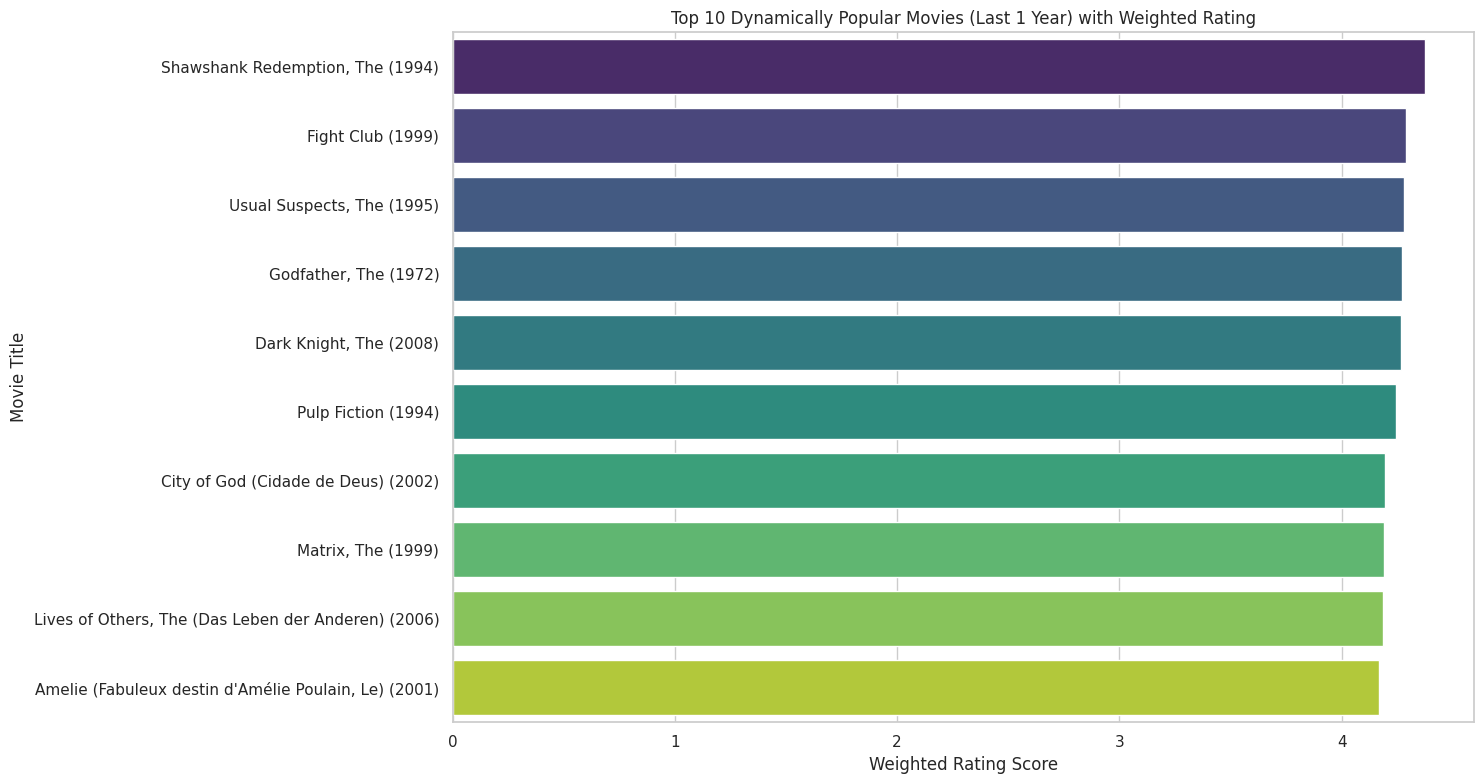

In [37]:
# Visualize the top 10 dynamically popular movies.
plt.figure(figsize=(15, 8))
sns.barplot(x='weighted_rating', y='title', data=dynamic_popular_recommendations.head(10), palette='viridis')
plt.title(f'Top 10 Dynamically Popular Movies (Last 1 Year) with Weighted Rating')
plt.xlabel('Weighted Rating Score')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

### Recommendation Function for General Use

In [38]:
# Define a function to easily retrieve dynamic popular recommendations for a general user.
def get_dynamic_popular_recommendations(num_recommendations=10):
    return dynamic_popular_recommendations.head(num_recommendations)[['title', 'genres', 'weighted_rating']]

print("\n--- Dynamic Popular Recommendations for General Users ---")
get_dynamic_popular_recommendations(10)


--- Dynamic Popular Recommendations for General Users ---


,title,genres,weighted_rating
281,"Shawshank Redemption, The (1994)",Drama,4.376138
2517,Fight Club (1999),Action Crime Drama Thriller,4.290930
49,"Usual Suspects, The (1995)",Crime Mystery Thriller,4.280647
710,"Godfather, The (1972)",Crime Drama,4.270334
9246,"Dark Knight, The (2008)",Action Crime Drama IMAX,4.265464
263,Pulp Fiction (1994),Comedy Crime Drama,4.242702
5216,City of God (Cidade de Deus) (2002),Action Crime Drama,4.192457
2179,"Matrix, The (1999)",Action Sci-Fi Thriller,4.191434
8499,"Lives of Others, The (Das Leben der Anderen) (...",Drama,4.184784
4301,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy Romance,4.165751


# Conclusion and Analysis

Setelah menjalankan kedua bagian di atas, kamu bisa menulis kesimpulan di sini.
Bandingkan jenis rekomendasi yang dihasilkan oleh masing-masing model.
- Content-Based: Fokus pada kemiripan kata kunci judul film.
- Collaborative Filtering (Popularitas Dinamis): Fokus pada tren popularitas terbaru berdasarkan rating.

Contoh:
"Dari hasil Content-Based Filtering, terlihat bahwa rekomendasi didasarkan pada kata kunci dalam judul.
Film-film yang direkomendasikan memiliki tema atau subjek yang mirip dengan film input,
yang ditangkap melalui analisis TF-IDF pada judul.
Sementara itu, Dynamic Popularity-Based Collaborative Filtering memberikan daftar film yang sedang naik daun
berdasarkan interaksi rating terbaru dari komunitas pengguna. Rekomendasi ini bersifat umum dan cocok
untuk menemukan tren atau untuk pengguna baru."